# Kaggle Mini Project
## BBC News Article Classification - Unsupervised Learning


### Overview

Content Classification is a task that can be approached from many different angles. In this particular report, the primary goal is to classify BBC News articles using Matrix Factorization. This is an unsupervised learning approach that can be done to "group" objects (articles, in this case) based on their similarity (or dissimilarity).

In [247]:
#General libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#EDA and model-relevant libraries
import re
import nltk.corpus
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import digits
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
%matplotlib inline
pd.options.mode.chained_assignment = None


### Exploratory Data Analysis (EDA)

#### Initial Data Read-In and Analysis

The train and test data will be read in. Some initial exploratory analysis will be conducted to get a general idea of the structure of the data. 

In [150]:
#Load in the data
##Training data
train_data = pd.read_csv("BBC News Train.csv")
##Test data
test_data = pd.read_csv("BBC News Test.csv")


In [36]:
train_data.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [37]:
test_data.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [38]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB


In [77]:
print(len(train_data))
print(len(test_data))
train_data.describe()

1490
735


,ArticleId
count,1490.000000
mean,1119.696644
std,641.826283
min,2.000000
25%,565.250000
50%,1112.500000
75%,1680.750000
max,2224.000000


In [78]:
#Ensure all of the training data is unique - by article number
print(train_data['ArticleId'].nunique())

#Ensure all categories are accounted for
print(train_data['Category'].unique())


1490
['business' 'tech' 'politics' 'sport' 'entertainment']


In [41]:
#Print out sample row to see what the data currently looks like
train_data['Text'][10]

'blair rejects iraq advice calls tony blair has rejected calls for the publication of advice on the legality of the iraq war amid growing calls for an investigation.  the prime minister told his monthly press conference the matter had been dealt with by the attorney general. earlier  conservative mp michael mates joined calls for a probe into claims lord goldsmith s statement to parliament was drawn up at number 10. mr blair said the statement was a  fair summary  of lord goldsmith s opinion.   that s what he (lord goldsmith) said and that s what i say. he has dealt with this time and time and time again   mr blair told his monthly news conference in downing street. he refused to answer further questions on the issue  saying it had been dealt with  literally scores of times and the position has not changed . lord goldsmith has denied being  leaned on  and says the words written were his.  the government refuses to publish his advice on the legality of the war - saying such papers have 

Reading in and exploring the initial data reveals that there are 1490 entries for the training data, and 735 entries for the test data. Since there are 1490 unique values for the ArticleId column, we can assume that each row represents a unique article. There are three columns in the training data: 
1. ArticleId - a unique numeric value used to identify articles.
2. Text - the heading and body of a given article.
3. Category - the category of the article, separated into five classes: business, tech, politics, sport, and entertainment. 

The goal for this project is to use matrix factorization to classify articles into one of the five categories mentioned above. Before proceeding with this, some preprocessing will be done to modifying the exising data to be machine-readable and readily available for model development. 

A sample row has been displayed above to see what the text data currently looks like.

#### Preprocessing and Exploratory Visualizations

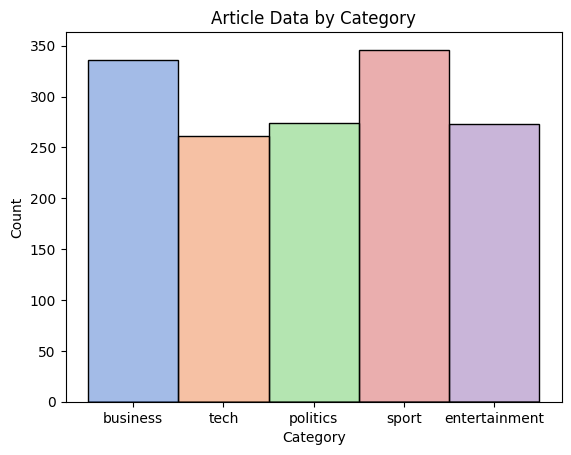

In [79]:
sns.histplot(
    data = train_data,
    x = 'Category',
    hue = 'Category',
    palette = 'muted',
    legend = False,
).set(
    title = 'Article Data by Category'
)
plt.show()

The proportion of each category by article type is roughly the same. This is an important detail, particulary when considering the influence on the size of each category on training of a model. 

Next, some standard procedures for natural language processing (NLP) will be conducted to ensure that the data is machine readable. This involves removing non-words (punctuation and non-text numbers) and stop words (such as "to", "and", and "of"). 

In [151]:
#Create a helper function to clean text data. This will be useful for cleaning the training and test data. 
def text_cleaner(df, column):
    #Remove punctuation
    df['clean'] = df[column].apply(lambda row: re.sub(
        r'[^\w\s]+', '', row
    ))

    #Remove numbers (non-text)
    df['clean'] = df['clean'].apply(lambda row: re.sub(
        r'[0-9]+', '', row
    ))
    #Remove stopwords
    sw = stopwords.words('english')
    df['clean'] = df['clean'].apply(lambda n: ' '.join(
        [word for word in n.split() if word not in (sw)]
    ))
    #Return clean data
    df['clean'] = df['clean'].apply(lambda m: re.sub(' +', ' ', m))
    return

In [152]:
#Use helper function to clean test data
text_cleaner(train_data, 'Text')
train_data.head()

,ArticleId,Text,Category,clean
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens maj...
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster better ...
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses payout eighteen former enron dire...


After doing some preliminary preprocessing, major grammatical and syntactical considerations to make the data machine readable have been completed. However, there are a couple of additional steps required to prepare the data for model building. 

Next, the data will be **lemmatized**. In this context, to lemmatize the text means to reduce words down to their root form. The text will simultanenously be changed to lowercase letters to ensure consistency across all inputs.

Another approach is **stemming**. However, this approach will not be taken, since it tends to remove prefixes or suffixes entirely, potentially leading to the introduction of non-words. 

The next step is to **tokenize** the text, meaning it will be broken down into a series of individual words (instead of a single string).


In [153]:
# tokenize text function
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    lem = [wordnet_lemmatizer.lemmatize(word.lower()) for word in text] 
    return lem

def tokenize_lemmatize_text(dataframe, t_string):
    dataframe['tokenized'] = dataframe.apply(lambda row: nltk.word_tokenize(row[t_string]), axis=1)
    dataframe['lemmatized'] = dataframe['tokenized'].apply(lambda string: lemmatize_text(string))
    dataframe['word_count'] = dataframe['lemmatized'].apply(lambda lst: len(lst))
    return

In [154]:
#Further clean the text using the functions above
tokenize_lemmatize_text(train_data, 'clean')
train_data.head()

,ArticleId,Text,Category,clean,tokenized,lemmatized,word_count
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launch, defence, lawyer, de...",185
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,"[german, business, confidence, slides, german,...","[german, business, confidence, slide, german, ...",194
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens maj...,"[bbc, poll, indicates, economic, gloom, citize...","[bbc, poll, indicates, economic, gloom, citize...",267
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster better ...,"[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...",344
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses payout eighteen former enron dire...,"[enron, bosses, payout, eighteen, former, enro...","[enron, boss, payout, eighteen, former, enron,...",198


In [134]:
train_data['lemmatized'][10]

['blair',
 'reject',
 'iraq',
 'advice',
 'call',
 'tony',
 'blair',
 'rejected',
 'call',
 'publication',
 'advice',
 'legality',
 'iraq',
 'war',
 'amid',
 'growing',
 'call',
 'investigation',
 'prime',
 'minister',
 'told',
 'monthly',
 'press',
 'conference',
 'matter',
 'dealt',
 'attorney',
 'general',
 'earlier',
 'conservative',
 'mp',
 'michael',
 'mate',
 'joined',
 'call',
 'probe',
 'claim',
 'lord',
 'goldsmith',
 'statement',
 'parliament',
 'drawn',
 'number',
 'mr',
 'blair',
 'said',
 'statement',
 'fair',
 'summary',
 'lord',
 'goldsmith',
 'opinion',
 'lord',
 'goldsmith',
 'said',
 'say',
 'dealt',
 'time',
 'time',
 'time',
 'mr',
 'blair',
 'told',
 'monthly',
 'news',
 'conference',
 'downing',
 'street',
 'refused',
 'answer',
 'question',
 'issue',
 'saying',
 'dealt',
 'literally',
 'score',
 'time',
 'position',
 'changed',
 'lord',
 'goldsmith',
 'denied',
 'leaned',
 'say',
 'word',
 'written',
 'government',
 'refuse',
 'publish',
 'advice',
 'legality',


In [155]:
train_data['Preprocessed'] = train_data['lemmatized'].apply(lambda l: " ".join(l))
train_data.head()

,ArticleId,Text,Category,clean,tokenized,lemmatized,word_count,Preprocessed
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launch, defence, lawyer, de...",185,worldcom exboss launch defence lawyer defendin...
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,"[german, business, confidence, slides, german,...","[german, business, confidence, slide, german, ...",194,german business confidence slide german busine...
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens maj...,"[bbc, poll, indicates, economic, gloom, citize...","[bbc, poll, indicates, economic, gloom, citize...",267,bbc poll indicates economic gloom citizen majo...
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster better ...,"[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...",344,lifestyle governs mobile choice faster better ...
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses payout eighteen former enron dire...,"[enron, bosses, payout, eighteen, former, enro...","[enron, boss, payout, eighteen, former, enron,...",198,enron boss payout eighteen former enron direct...


After tokenizing and lemmatizing the text, the data is in an appropriate state for model building. However, before fitting a model, analysis of the word counts will be done. To ensure that "wordier" articles do not inflate the feature count, we can remove outlying values.

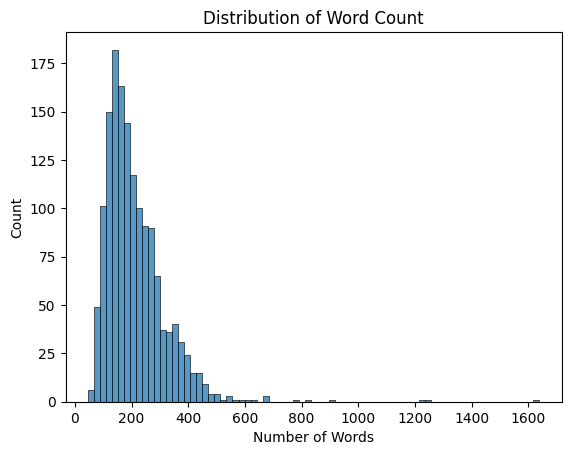

In [156]:
sns.histplot(
    data = train_data,
    x = 'word_count'
).set(
    title = 'Distribution of Word Count',
    xlabel = 'Number of Words'
)

plt.show()

The distribution reveals that most articles have roughly between 200 and 400 words. Some outlying values can be seen that have significantly more words than other articles. To take a look at what is considered "outlying", quartiles will be calculated and outliers will be removed using interquartile range as a metric. 

In [157]:
#Determine quantile values
q1 = train_data['word_count'].quantile(0.25)
q3 = train_data['word_count'].quantile(0.75)
print('Quartiles:')
print("Lower quartile, q1: ", q1)
print("Upper quartile, q3: ", q3)
iqr = q3 - q1
q_upper = q3 + 1.5*iqr
q_lower = q1 - 1.5*iqr


#Remove articles "outlying" using the IQR values calculated above
train_data_clean = train_data[(train_data['word_count'] > q_lower) & (train_data['word_count'] < q_upper)]
print("New dataframe length: ", len(train_data_clean))

Quartiles:
Lower quartile, q1:  139.0
Upper quartile, q3:  261.75
New dataframe length:  1456


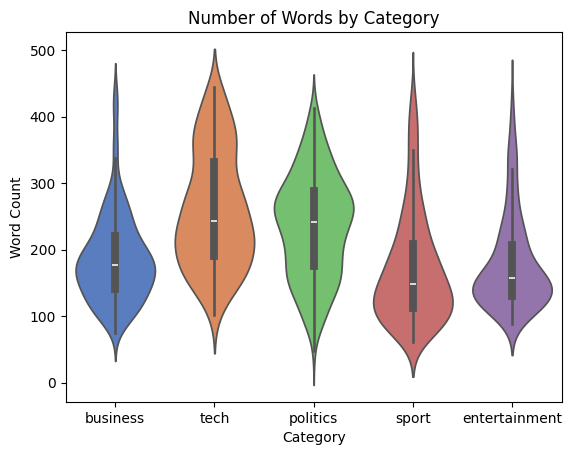

In [158]:
#Plot number of words by category after preprocessing
sns.violinplot(
    data = train_data_clean,
    x = 'Category',
    hue = 'Category',
    y = 'word_count',
    palette = 'muted',
    legend = False
).set(
    title = 'Number of Words by Category',
    xlabel = 'Category',
    ylabel = 'Word Count'
)
plt.show()

The tech and politics categories have the highest average word counts, which is higher than the other three categories. However, after the initial preprocessing step to limit word count, the relative frequency of word count by category is within 100 words.

Before fitting a model, numeric factor column will be added. This value represents each of the categories for classification purposes, but will be a numeric representation for ease-of-use with the tools to be used in training the model. 

In [159]:
#Add numeric factor column
vals, unique = pd.factorize(train_data_clean['Category'])
train_data_clean['X_Target'] = vals
train_data_clean

,ArticleId,Text,Category,clean,tokenized,lemmatized,word_count,Preprocessed,X_Target
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launch, defence, lawyer, de...",185,worldcom exboss launch defence lawyer defendin...,0
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,"[german, business, confidence, slides, german,...","[german, business, confidence, slide, german, ...",194,german business confidence slide german busine...,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens maj...,"[bbc, poll, indicates, economic, gloom, citize...","[bbc, poll, indicates, economic, gloom, citize...",267,bbc poll indicates economic gloom citizen majo...,0
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster better ...,"[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...",344,lifestyle governs mobile choice faster better ...,1
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses payout eighteen former enron dire...,"[enron, bosses, payout, eighteen, former, enro...","[enron, boss, payout, eighteen, former, enron,...",198,enron boss payout eighteen former enron direct...,0
...,...,...,...,...,...,...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment,double eviction big brother model caprice holb...,"[double, eviction, big, brother, model, capric...","[double, eviction, big, brother, model, capric...",116,double eviction big brother model caprice holb...,4
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,dj double act revamp chart show dj duo jk joel...,"[dj, double, act, revamp, chart, show, dj, duo...","[dj, double, act, revamp, chart, show, dj, duo...",306,dj double act revamp chart show dj duo jk joel...,4
1487,1590,weak dollar hits reuters revenues at media gro...,business,weak dollar hits reuters revenues media group ...,"[weak, dollar, hits, reuters, revenues, media,...","[weak, dollar, hit, reuters, revenue, medium, ...",127,weak dollar hit reuters revenue medium group r...,0
1488,1587,apple ipod family expands market apple has exp...,tech,apple ipod family expands market apple expande...,"[apple, ipod, family, expands, market, apple, ...","[apple, ipod, family, expands, market, apple, ...",316,apple ipod family expands market apple expande...,1


### Model Building and Training

#### Term Frequency - Inverse Document Frequency (TF - IDF)

Term Frequency - Inverse Document Frequency (TF - IDF), in short, is a way to calculate the relevance of a word for a given text object (document). As the name implies, the value will increase proportionally to the number of times a word appears in an individual document, balanced out by the word frequency of the word in the entire dataset (across all documents). 

Another benefit of using this measure is that the output will be a matrix of numeric values. This format will lend itself well to matrix factorization (opposed to a series of words). 


In [ ]:
#Use the td-idf vectorizer

tfidf_vec = TfidfVectorizer(
    #Ignore terms that appear in less than 5% of documents
    min_df = 0.05,
    #Ignore terms that appear in more than 95% of documents
    max_df = 0.95,
    #We will use the 'clean' column; we will keep an eye out for stopwords.
    stop_words= 'english'
)

#Create X_train dataset using the tf-idf vectorizer
#We use the 'clean' column here - the vectorizer will lemmatize and tokenize. 
X_train = tfidf_vec.fit_transform(train_data_clean['Preprocessed'])



In [180]:
pd.DataFrame(X_train.toarray(), columns = tfidf_vec.get_feature_names_out())

,able,access,according,account,accused,act,action,actor,added,admitted,...,winner,winning,woman,work,working,world,year,yearold,york,young
0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.050323,0.00000,0.126199,0.000000
1,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.038441,0.00000,0.000000,0.000000
2,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.315919,0.023793,0.00000,0.000000,0.000000
3,0.037541,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.018155,0.00000,0.000000,0.000000
4,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.183165,0.00000,0.068677,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.043958,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.16747,0.000000,0.0,...,0.324066,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000
1452,0.000000,0.0,0.000000,0.0,0.0,0.142986,0.000000,0.00000,0.000000,0.0,...,0.000000,0.069987,0.0,0.0,0.0,0.000000,0.029507,0.06136,0.000000,0.000000
1453,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.077764,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.298645,0.00000,0.000000,0.000000
1454,0.000000,0.0,0.120029,0.0,0.0,0.000000,0.000000,0.00000,0.064599,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.020674,0.00000,0.000000,0.050091


In [167]:
#Create model
nmf_model = NMF(
    n_components = 5,
    random_state= 42,
    solver = 'mu',
    beta_loss = 'kullback-leibler'
)

nmf_trained = nmf_model.fit(X_train)

Now that the model has been fit, it is of interest to look at word frequency patterns before moving on to model evaluation.

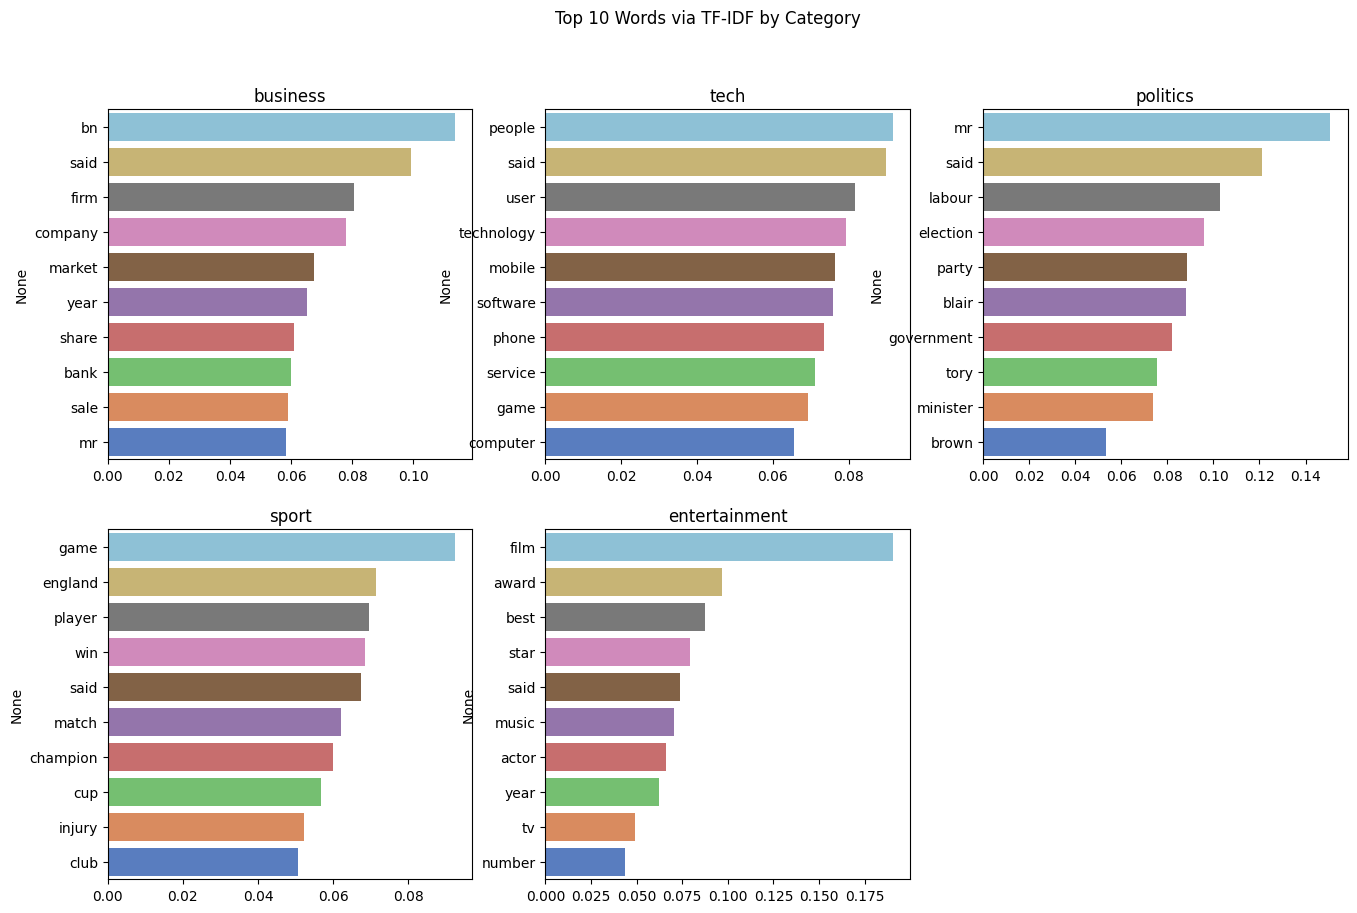

In [189]:
#Initialize subplot shape
fig, axes = plt.subplots(2, 3, figsize = (16, 10))
#Extract top 10 words by category from TF-IDF
tmp = pd.DataFrame(X_train.todense(), columns = tfidf_vec.get_feature_names_out(), index = train_data_clean.index)
tmp['Category'] = train_data_clean['Category']
axes = axes.flatten()

for ax, category in zip(axes, tmp['Category'].unique()):
    #Get top 10 words by category
    data = tmp[tmp['Category'] == category].loc[:, tmp.columns != "Category"].mean().sort_values(ascending = False)[:10]
    sns.barplot(
        x = data.values,
        y = data.index,
        hue = data.values,
        legend = False,
        palette = 'muted',
        ax = ax
    )
    ax.set_title(category, fontsize = 12)

fig.suptitle('Top 10 Words via TF-IDF by Category')
fig.delaxes(axes[5])

This graph provides an interesting look into the word frequency (post TF-IDF) will influence the NMF model. 

### Model Evaluation and Comparisons

To evaluate the model, the class labels must first be mapped to the original categories (since the labels have been randomly assigned). A helper function will assist in finding the permutation that best maps category labels to the output of the NMF model.

In [197]:
#Create a function to find the best permutation of labels
def label_permute(ytdf,yp,n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    perms = list(itertools.permutations([0, 1, 2, 3, 4]))    #create permutation list
    best_labels = []
    best_acc = 0 
    current = {}
    labs = ['business', 'tech', 'politics', 'sport', 'entertainment']
    for perm in perms:
        for i in range(n):
            current[labs[i]] = perm[i]
            if len(current) == 5:
                conditions = [
                    (ytdf['Category'] == current['business']),
                    (ytdf['Category'] == current['tech']),
                    (ytdf['Category'] == current['politics']),
                    (ytdf['Category'] == current['sport']),
                    (ytdf['Category'] == current['entertainment'])]
                ytdf['test'] = ytdf['Category'].map(current)
                current_accuracy = accuracy_score(ytdf['test'], yp)
                if current_accuracy > best_acc: 
                    best_acc = current_accuracy
                    best_labels = perm
                    ytdf['best'] = ytdf['test']
    return best_labels, best_acc

def predict(mat):
    sortedM = np.argsort(mat)
    n_predictions, maxValue = sortedM.shape
    predictions = [[sortedM[i][maxValue - 1]] for i in range(n_predictions)]
    topics = np.empty(n_predictions, dtype = np.int64)
    for i in range(n_predictions):
        topics[i] = predictions[i][0]
    return topics

In [210]:
#view results
yhat_train = predict(nmf_model.transform(X_train))
label_order, accuracy = label_permute(train_data_clean, yhat_train )
print('accuracy=', accuracy)
print('label order : ', label_order)

accuracy= 0.9223901098901099
label order :  (0, 4, 3, 1, 2)


A training accuracy score of 92.2% was achieved using this model and the best permutation of labels. To take a look at how this looks on a case-by-case basis, a confusion matrix can be created. 

In [219]:
#First, we need to remap values to the correct output values
val_map = {0:0, 4:1, 3:2, 1:3, 2:4}

def mp(entry):
    return val_map[entry] if entry in val_map else entry

mp = np.vectorize(mp)

yhat_train_arr = mp(yhat_train)

print(train_data_clean['X_Target'])
print(yhat_train_arr)

0       0
1       0
2       0
3       1
4       0
       ..
1485    4
1486    4
1487    0
1488    1
1489    1
Name: X_Target, Length: 1456, dtype: int64
[0 0 0 ... 0 1 1]


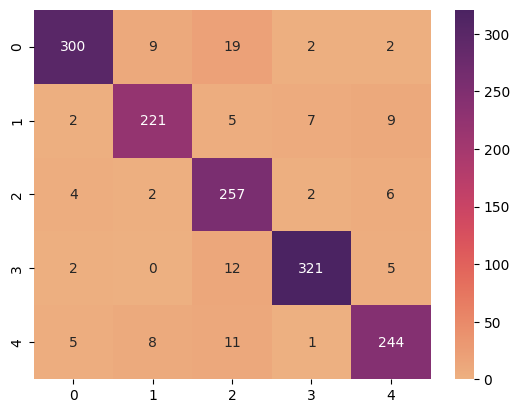

In [233]:
#Create confusion matrix heatmap
sns.heatmap(
    confusion_matrix(train_data_clean['X_Target'], yhat_train_arr),
    annot = True,
    fmt = 'd',
    cmap = 'flare'
)
plt.show()

In [ ]:

train_data_clean_output = train_data_clean
train_data_clean_output['y_pred'] = yhat_train_arr.tolist()
train_data_clean_output

{0: 'Business', 1: 'Tech', 2: 'Politics', 3: 'Sport', 4: 'Entertainment'}


,ArticleId,Text,Category,clean,tokenized,lemmatized,word_count,Preprocessed,X_Target,test,best,y_pred
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launch, defence, lawyer, de...",185,worldcom exboss launch defence lawyer defendin...,0,4,0,0
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,"[german, business, confidence, slides, german,...","[german, business, confidence, slide, german, ...",194,german business confidence slide german busine...,0,4,0,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens maj...,"[bbc, poll, indicates, economic, gloom, citize...","[bbc, poll, indicates, economic, gloom, citize...",267,bbc poll indicates economic gloom citizen majo...,0,4,0,0
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster better ...,"[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...",344,lifestyle governs mobile choice faster better ...,1,3,4,1
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses payout eighteen former enron dire...,"[enron, bosses, payout, eighteen, former, enro...","[enron, boss, payout, eighteen, former, enron,...",198,enron boss payout eighteen former enron direct...,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment,double eviction big brother model caprice holb...,"[double, eviction, big, brother, model, capric...","[double, eviction, big, brother, model, capric...",116,double eviction big brother model caprice holb...,4,0,2,4
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,dj double act revamp chart show dj duo jk joel...,"[dj, double, act, revamp, chart, show, dj, duo...","[dj, double, act, revamp, chart, show, dj, duo...",306,dj double act revamp chart show dj duo jk joel...,4,0,2,4
1487,1590,weak dollar hits reuters revenues at media gro...,business,weak dollar hits reuters revenues media group ...,"[weak, dollar, hits, reuters, revenues, media,...","[weak, dollar, hit, reuters, revenue, medium, ...",127,weak dollar hit reuters revenue medium group r...,0,4,0,0
1488,1587,apple ipod family expands market apple has exp...,tech,apple ipod family expands market apple expande...,"[apple, ipod, family, expands, market, apple, ...","[apple, ipod, family, expands, market, apple, ...",316,apple ipod family expands market apple expande...,1,3,4,1


In [240]:
label_dict = {0: 'Business', 
              1: 'Sport',
              2: 'Entertainment',
              3: 'Politics',
              4: 'Tech'}

Now that the model has been created, we can determine performance on the test set. 

In [228]:
text_cleaner(test_data, 'Text')
test_data


,ArticleId,Text,clean
0,1018,qpr keeper day heads for preston queens park r...,qpr keeper day heads preston queens park range...
1,1319,software watching while you work software that...,software watching work software monitor every ...
2,1138,d arcy injury adds to ireland woe gordon d arc...,arcy injury adds ireland woe gordon arcy ruled...
3,459,india s reliance family feud heats up the ongo...,india reliance family feud heats ongoing publi...
4,1020,boro suffer morrison injury blow middlesbrough...,boro suffer morrison injury blow middlesbrough...
...,...,...,...
730,1923,eu to probe alitalia state aid the european ...,eu probe alitalia state aid european commissio...
731,373,u2 to play at grammy awards show irish rock ba...,u play grammy awards show irish rock band u pl...
732,1704,sport betting rules in spotlight a group of mp...,sport betting rules spotlight group mps peers ...
733,206,alfa romeos to get gm engines fiat is to sto...,alfa romeos get gm engines fiat stop making si...


In [229]:
tokenize_lemmatize_text(test_data, 'clean')
test_data


,ArticleId,Text,clean,tokenized,lemmatized,word_count
0,1018,qpr keeper day heads for preston queens park r...,qpr keeper day heads preston queens park range...,"[qpr, keeper, day, heads, preston, queens, par...","[qpr, keeper, day, head, preston, queen, park,...",86
1,1319,software watching while you work software that...,software watching work software monitor every ...,"[software, watching, work, software, monitor, ...","[software, watching, work, software, monitor, ...",232
2,1138,d arcy injury adds to ireland woe gordon d arc...,arcy injury adds ireland woe gordon arcy ruled...,"[arcy, injury, adds, ireland, woe, gordon, arc...","[arcy, injury, add, ireland, woe, gordon, arcy...",135
3,459,india s reliance family feud heats up the ongo...,india reliance family feud heats ongoing publi...,"[india, reliance, family, feud, heats, ongoing...","[india, reliance, family, feud, heat, ongoing,...",174
4,1020,boro suffer morrison injury blow middlesbrough...,boro suffer morrison injury blow middlesbrough...,"[boro, suffer, morrison, injury, blow, middles...","[boro, suffer, morrison, injury, blow, middles...",71
...,...,...,...,...,...,...
730,1923,eu to probe alitalia state aid the european ...,eu probe alitalia state aid european commissio...,"[eu, probe, alitalia, state, aid, european, co...","[eu, probe, alitalia, state, aid, european, co...",169
731,373,u2 to play at grammy awards show irish rock ba...,u play grammy awards show irish rock band u pl...,"[u, play, grammy, awards, show, irish, rock, b...","[u, play, grammy, award, show, irish, rock, ba...",120
732,1704,sport betting rules in spotlight a group of mp...,sport betting rules spotlight group mps peers ...,"[sport, betting, rules, spotlight, group, mps,...","[sport, betting, rule, spotlight, group, mp, p...",210
733,206,alfa romeos to get gm engines fiat is to sto...,alfa romeos get gm engines fiat stop making si...,"[alfa, romeos, get, gm, engines, fiat, stop, m...","[alfa, romeo, get, gm, engine, fiat, stop, mak...",158


In [230]:
test_data['Preprocessed'] = test_data['lemmatized'].apply(lambda l: " ".join(l))
test_data.head()

,ArticleId,Text,clean,tokenized,lemmatized,word_count,Preprocessed
0,1018,qpr keeper day heads for preston queens park r...,qpr keeper day heads preston queens park range...,"[qpr, keeper, day, heads, preston, queens, par...","[qpr, keeper, day, head, preston, queen, park,...",86,qpr keeper day head preston queen park ranger ...
1,1319,software watching while you work software that...,software watching work software monitor every ...,"[software, watching, work, software, monitor, ...","[software, watching, work, software, monitor, ...",232,software watching work software monitor every ...
2,1138,d arcy injury adds to ireland woe gordon d arc...,arcy injury adds ireland woe gordon arcy ruled...,"[arcy, injury, adds, ireland, woe, gordon, arc...","[arcy, injury, add, ireland, woe, gordon, arcy...",135,arcy injury add ireland woe gordon arcy ruled ...
3,459,india s reliance family feud heats up the ongo...,india reliance family feud heats ongoing publi...,"[india, reliance, family, feud, heats, ongoing...","[india, reliance, family, feud, heat, ongoing,...",174,india reliance family feud heat ongoing public...
4,1020,boro suffer morrison injury blow middlesbrough...,boro suffer morrison injury blow middlesbrough...,"[boro, suffer, morrison, injury, blow, middles...","[boro, suffer, morrison, injury, blow, middles...",71,boro suffer morrison injury blow middlesbrough...


In [257]:
X_test = tfidf_vec.fit_transform(test_data['Preprocessed'])
y_test = predict(nmf_model.transform(X_test))

In [259]:
X_test.shape

(735, 534)

In [242]:
predictions_test = pd.DataFrame(columns = 
                                ['ArticleId',
                                 'Category',
                                 'yhat'])

predictions_test['ArticleId'] = test_data['ArticleId']
predictions_test['yhat'] = y_test
predictions_test['Category'] = predictions_test['yhat'].apply(lambda x: label_dict[x])


In [243]:
predictions_test = predictions_test.drop('yhat', axis = 1)

In [245]:
predictions_test.head(15)

,ArticleId,Category
0,1018,Sport
1,1319,Tech
2,1138,Sport
3,459,Entertainment
4,1020,Sport
5,51,Sport
6,2025,Business
7,1479,Business
8,27,Politics
9,397,Entertainment


### Supervised Learning?

To see if performance is improved through supervised methods, a series of supervised learning models can be run to assess performance. 


In [261]:
#Load in models
log_reg = LogisticRegression(random_state=42)
random_forest = RandomForestClassifier(random_state=42)
svm = SVC(random_state=42)
knn = KNeighborsClassifier()
#Create loop to fit models and test accuracy
mod_list = [log_reg, random_forest, svm, knn]
train_preds = {}
test_preds = {}
for model in mod_list:
    model.fit(X_train, train_data_clean['X_Target'])
    #Make predictions
    y_train_pred = model.predict(X_train)
    train_preds[f'{model.__class__.__name__}'] = y_train_pred
    print(f'{model.__class__.__name__} train accuracy: {accuracy_score(train_data_clean["X_Target"], y_train_pred)}')
    print('-'*10)



LogisticRegression train accuracy: 0.9869505494505495
----------
RandomForestClassifier train accuracy: 1.0
----------
SVC train accuracy: 0.9993131868131868
----------
KNeighborsClassifier train accuracy: 0.9395604395604396
----------


These models seem to have considerably high performance for the training data, with the random forest method having the best results. To take a closer look at the errors, confusion matrices will be created for the data. 

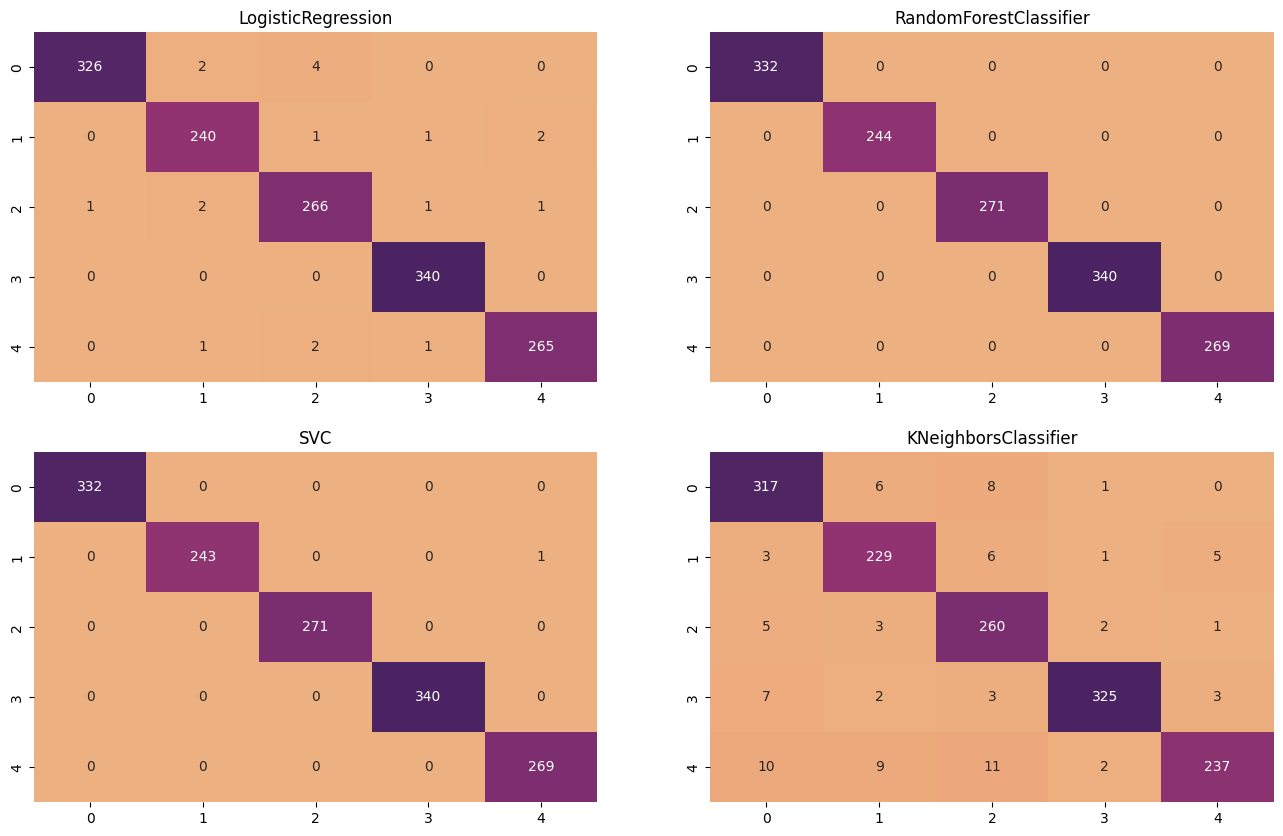

In [263]:
fig, ax = plt.subplots(2, 2, figsize = (16, 10))
for axis, model in zip(ax.flatten(), train_preds):
    predictions = train_preds[model]
    sns.heatmap(confusion_matrix(train_data_clean['X_Target'], predictions),
        annot = True,
        fmt = 'd',
        cmap = 'flare',
        cbar = False,
        ax = axis
    )
    axis.set_title(f'{model}')


### Conclusion

In conclusion, both supervised and unsupervised learning methods may be used to tackle the task of content classification. This project has shown that there are strengths and weaknesses to each model type.

### References
The following resources were used for this project:

https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/

https://sandipanweb.wordpress.com/2023/12/06/non-negative-matrix-factorization-to-solve-text-classification-and-recommendation-problems/

https://www.analyticsvidhya.com/blog/2021/05/natural-language-processing-step-by-step-guide/

https://scikit-learn.org/1.5/modules/generated/sklearn.decomposition.NMF.html

https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
